In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_blobs

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
torch.__version__

'1.5.0'

In [3]:
c = 0.01
lr = 0.1
batchsize = 5
num_epochs = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
X, y = make_blobs(n_samples=500, centers=2, random_state=0,
                  cluster_std=0.4)
X = (X - X.mean()) / X.std()
y[np.where(y == 0)] = -1
X.shape,y.shape

((500, 2), (500,))

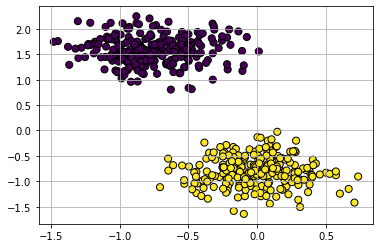

In [5]:
plt.scatter(X[:,0], X[:,1],c=y,marker='o', edgecolor='black',s=50)
plt.grid();

In [6]:
class SVM(nn.Module):
    def __init__(self,num_in,num_out):
        super(SVM,self).__init__()
        self.linear=nn.Linear(num_in,num_out)
    def forward(self,x):
        return self.linear(x)
    
model = SVM(2,1)    
model.to(device)

SVM(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)

In [7]:
X_t = torch.FloatTensor(X).to(device)
y_t = torch.FloatTensor(y).to(device)


optimizer = optim.SGD(model.parameters(), lr=lr)


#### Loss function

<div style="font-size: 115%;">
$$\frac{1}{2}||\vec{w}||^2 \text{ subject to }y_i(\vec{x}_i\vec{w} + b ) - 1 = 0  \text{  }$$
</div>

In [8]:
def svm_loss(w,y,lin_out,c):
    constraint = torch.mean(torch.clamp(1 - y * lin_out, min=0)) #>= 0
    return c*torch.dot(w.t(),w)/2.0 + constraint

In [9]:
def train(X, Y, model, batchsize,epochs,c):
    N = len(Y)
    model.train()
    for epoch in range(epochs):
        perm = torch.randperm(N)
        sum_loss = 0

        for i in range(0, N, batchsize):
            x = X[perm[i : i + batchsize]]
            y = Y[perm[i : i + batchsize]]

            optimizer.zero_grad()
            output = model(x).squeeze()
            weight = model.linear.weight.squeeze()
            
            loss = svm_loss(weight,y,output,c)
            loss.backward()
            optimizer.step()

            sum_loss += float(loss)

        print("Epoch: {:4d}\tloss: {}".format(epoch, sum_loss / N))

In [10]:
def visualize(X, Y, model):
    W = model.linear.weight.squeeze().detach().cpu().numpy()
    b = model.linear.bias.squeeze().detach().cpu().numpy()

    delta = 0.001
    x = np.arange(X[:, 0].min(), X[:, 0].max(), delta)
    y = np.arange(X[:, 1].min(), X[:, 1].max(), delta)
    x, y = np.meshgrid(x, y)
    xy = list(map(np.ravel, [x, y]))

    z = (W.dot(xy) + b).reshape(x.shape)
    z[np.where(z > 1.0)] = 4
    z[np.where((z > 0.0) & (z <= 1.0))] = 3
    z[np.where((z > -1.0) & (z <= 0.0))] = 2
    z[np.where(z <= -1.0)] = 1

    plt.figure(figsize=(10, 10))
    plt.xlim([X[:, 0].min() + delta, X[:, 0].max() - delta])
    plt.ylim([X[:, 1].min() + delta, X[:, 1].max() - delta])
    plt.contourf(x, y, z, alpha=0.8, cmap="Greys")
    plt.scatter(x=X[:, 0], y=X[:, 1], c="black", s=10)
    plt.tight_layout()
  

In [11]:
train(X_t, y_t, model, batchsize, num_epochs, c)
visualize(X_t, y_t, model)

 https://github.com/kazuto1011

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [13]:
df = pd.read_csv('PurchaseData.csv')
df.tail()

,Gender,Age,Salary,Purchased
395,Female,46,41000,1
396,Male,51,23000,1
397,Female,50,20000,1
398,Male,36,33000,0
399,Female,49,36000,1


In [14]:
X = df.iloc[:, [1, 2]].values
y = df.iloc[:, 3].values
y[np.where(y == 0)] = -1

# Split the data into the training and test

X_train,X_test,y_train,y_test = train_test_split(X, y,  stratify= y,
                                                 test_size = 0.25,
                                                 random_state = 1234)
# Scale Age and Salary features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Convert data into torch tensors
X_train_t = torch.from_numpy(X_train.astype(np.float32)).to(device)
X_test_t = torch.from_numpy(X_test.astype(np.float32)).to(device)
y_train_t = torch.from_numpy(y_train.astype(np.float32).reshape(-1, 1)).to(device)
y_test_t = torch.from_numpy(y_test.astype(np.float32).reshape(-1, 1)).to(device)


X_train_t.shape,X_test_t.shape,y_train_t.shape,y_test_t.shape                                                 

(torch.Size([300, 2]),
 torch.Size([100, 2]),
 torch.Size([300, 1]),
 torch.Size([100, 1]))

In [19]:
train(X_train_t, y_train_t, model,10, 100, 10.0)


Epoch:    0	loss: 0.07257508629312118
Epoch:    1	loss: 0.07288900031087299
Epoch:    2	loss: 0.07242880942299962
Epoch:    3	loss: 0.07243889113267263
Epoch:    4	loss: 0.07286114330713947
Epoch:    5	loss: 0.072781999061505
Epoch:    6	loss: 0.07279523839553197
Epoch:    7	loss: 0.07267971626793344
Epoch:    8	loss: 0.07255598306655883
Epoch:    9	loss: 0.07238168920079867
Epoch:   10	loss: 0.07254401021326581
Epoch:   11	loss: 0.07225459579378367
Epoch:   12	loss: 0.07249789698670307
Epoch:   13	loss: 0.07218715550921237
Epoch:   14	loss: 0.0727175174218913
Epoch:   15	loss: 0.07272488892078399
Epoch:   16	loss: 0.07237999493877093
Epoch:   17	loss: 0.07225200533866882
Epoch:   18	loss: 0.07253266251490761
Epoch:   19	loss: 0.0731169027586778
Epoch:   20	loss: 0.07269152216613292
Epoch:   21	loss: 0.0725547382235527
Epoch:   22	loss: 0.07271033932765325
Epoch:   23	loss: 0.07264398326476415
Epoch:   24	loss: 0.07263297498226166
Epoch:   25	loss: 0.07256786977251371
Epoch:   26	loss:

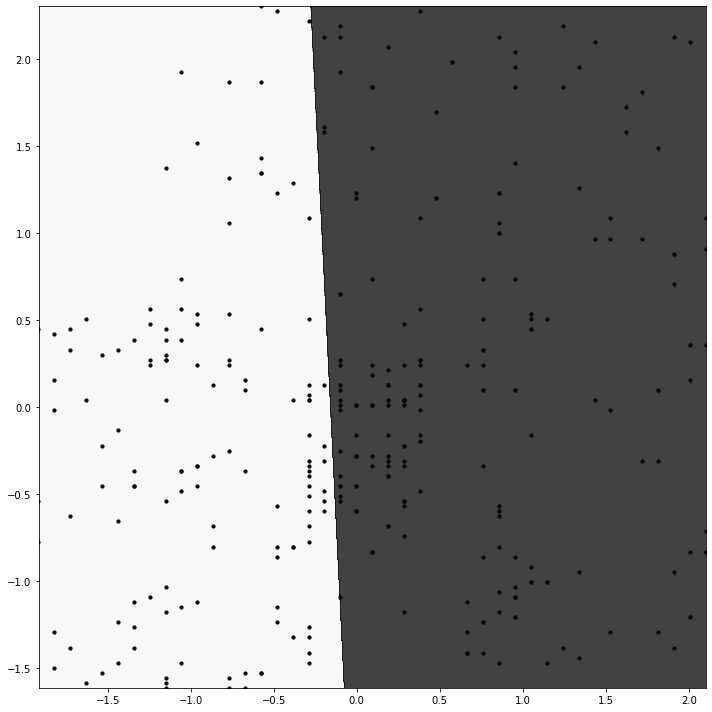

In [20]:
visualize(X_train_t, y_train_t, model)

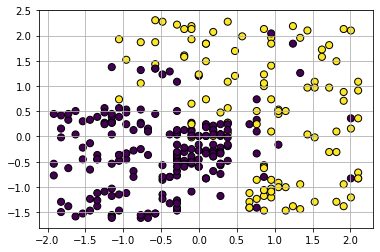

In [17]:
plt.scatter(X_train[:,0], X_train[:,1],c=y_train,marker='o', edgecolor='black',s=50)
plt.grid();